In [1]:
import keras.layers
from keras.utils import plot_model
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
from keras import regularizers

Using TensorFlow backend.


In [2]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import pandas as pd

In [3]:
class Params():
    """Class that loads hyperparameters from a json file.
    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    """

    def __init__(self, json_path):
        self.json_path = json_path

    def save(self, json_path):
        """Saves parameters to json file"""
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']`"""
        return self.__dict__

In [5]:
''' For Full Sized Data, please visit 
https://drive.google.com/open?id=1VHPcTypbq0oqV5CMCQ1H7W_Uj6iSzkL_
https://drive.google.com/open?id=1N72Jf5j6yRYAyP49qLrRVZbh6p2GJ5Uv
https://drive.google.com/open?id=1WzCHQV2074FStb427WRx2Ru7mAu6jUW6
'''
#xDataRaw = pickle.load(open( 'xDataMelSmaller.pkl', "rb" ))
#genreDataRaw = pickle.load(open( 'genreDataSmaller.pkl', "rb" ))
#featDataRaw = pickle.load(open( 'featDataSmaller.pkl', "rb" ))

''' I made a sample subset from the data set I actually used for you to test run'''
xDataRaw = pickle.load(open( 'xDataMelSample.pkl', "rb" ))
genreDataRaw = pickle.load(open( 'genreDataSample.pkl', "rb" ))
featDataRaw = pickle.load(open( 'featDataSample.pkl', "rb" ))

featDataRaw = featDataRaw[:,0:4]

xData = np.asarray(xDataRaw) / 255.0
genreData = np.array(genreDataRaw)
featData= np.array(featDataRaw)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(genreData)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
genres = onehot_encoder.fit_transform(integer_encoded)
print(genres)


[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [6]:
def ConvertValenceToLabel(data):
    if data<=.3:
        return 'Sad'
    elif (data>.3 and data<=.6):
        return 'moodNeutral'
    else:
        return 'Happy'
    

In [7]:
danceability = featData[:,0]
energy = featData[:,1]
valence = featData[:,2]
accousticness = featData[:,3]
ValenceData = []
for data in valence:
    ValenceData.extend([ConvertValenceToLabel(data) ])
    


In [8]:
label_encoder_valence = LabelEncoder()
onehot_encoder_valence = OneHotEncoder(sparse=False)
integer_encoded_Valence = label_encoder_valence.fit_transform(ValenceData)
integer_encoded_Valence = integer_encoded_Valence.reshape(len(integer_encoded_Valence), 1)
valenceOneHot = onehot_encoder.fit_transform(integer_encoded_Valence)
print(valenceOneHot)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [23]:
test_portion = .05
dev_portion = .05
test_size = round(len(xData)*test_portion)
dev_size = round(len(xData)*dev_portion)
randTotal= np.random.randint(1,len(xData),test_size+dev_size)
randTest = randTotal[0:test_size]
randDev = randTotal[test_size:]
origIndices= list(range(0, len(xData)))
trainIndices = [x for x in origIndices if x not in randTotal]

devX = xData[randDev]
devGenres =genres[randDev]
devValence =valenceOneHot[randDev]

trainX = xData[trainIndices]
trainGenres =genres[trainIndices]
trainValence =valenceOneHot[trainIndices]

testX = xData[randTest]
testGenres = genres[randTest]
testValence = valenceOneHot[randTest]


testX=testX.reshape(testX.shape[0],testX.shape[1],testX.shape[2],1)
trainX=trainX.reshape(trainX.shape[0],trainX.shape[1],trainX.shape[2],1)
devX = devX.reshape(devX.shape[0],devX.shape[1],devX.shape[2],1)

In [53]:
def buildZhang(width, height, depth,classesGenres,classesValence, param,activate="softmax"):

    regparam = param.regparam
    dropout = param.dropout
    
    inputShape = (height, width, depth)   
        
    visible = Input(inputShape, name='input1')   
    
    bn0=BatchNormalization(name='BN_input')(visible)    
    conv1 = Conv2D(filters=128, kernel_size=1, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same',name='Conv1')(bn0)   
    bn1 = BatchNormalization(name='BN_conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,1), padding='same', name='pool1')(bn1) 
    conv2 = Conv2D(filters=128, kernel_size=1, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv2')(pool1)    
    bn2 = BatchNormalization(name='BN_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,1), padding='same', name='pool2')(bn2)    
    conv3 =  Conv2D(filters=256, kernel_size=1, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv3')(pool2)   
    bn3 = BatchNormalization(name='BN_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(6,1),padding='same', name='pool3Max')(bn3)       
    pool4 = AveragePooling2D(pool_size=(6,1),padding='same', name='pool3Ave')(bn3)
    poolave = keras.layers.average([pool4,pool3], name='pool3Combined')
       
    flat = Flatten(name='Flatten')(poolave)
    dropd0=keras.layers.Dropout(dropout, name='Drop_Conv3')(flat)
      
    
    if param.FCLayers ==1:
         
        hidden1 = Dense(15, activation='relu',kernel_regularizer=regularizers.l2(regparam), name='FC1')(dropd0)
        bnd1 = BatchNormalization(name='BN_FC1')(hidden1)   
        dropd1 = keras.layers.Dropout(dropout, name='DropOut_FC1')(bnd1)          
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd1)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd1)
    else:
        hidden1 = Dense(300, activation='relu',kernel_regularizer=regularizers.l2(regparam), name='FC1')(dropd0)
        bnd1 = BatchNormalization(name='BN_FC1')(hidden1)   
        dropd1 = keras.layers.Dropout(dropout, name='DropOut_FC1')(bnd1) 
        hidden2 = Dense(150, activation='relu',kernel_regularizer=regularizers.l2(regparam), name='FC2')(dropd1)
        bnd2 = BatchNormalization(name='BN_FC2')(hidden2)   
        dropd2 = keras.layers.Dropout(dropout, name='DropOut_FC2')(bnd2)
        
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd2)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd2)
        
       
        
    modelFunc = Model(inputs=visible, outputs=[outputGenre,outputValence])
    
    return modelFunc


In [35]:
def buildChoi(width, height, depth,classesGenres,classesValence, param,activate="softmax"):

    regparam = param.regparam
    dropout = param.dropout
    
    inputShape = (height, width, depth)   
        
    visible = Input(inputShape, name='input1')   
    
    bn0=BatchNormalization(name='BN_input')(visible)    
    conv1 = Conv2D(filters=32, kernel_size=3, strides=3, activation='elu', 
                   kernel_initializer='glorot_normal',padding='same',name='Conv1')(bn0)   
    bn1 = BatchNormalization(name='BN_conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(1,2), padding='same', name='pool1')(bn1) 
    conv2 = Conv2D(filters=128, kernel_size=3, strides=3, activation='elu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv2')(pool1)    
    bn2 = BatchNormalization(name='BN_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(1,2), padding='same', name='pool2')(bn2)    
    conv3 =  Conv2D(filters=128, kernel_size=3, strides=3, activation='elu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv3')(pool2)   
    bn3 = BatchNormalization(name='BN_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(1,2),padding='same', name='pool3')(bn3)
    
    conv4 =  Conv2D(filters=192, kernel_size=3, strides=3, activation='elu', 
                   kernel_initializer='glorot_normal', padding='same', name='Conv4')(pool3)
    bn4 = BatchNormalization(name='BN_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(3,5),padding='same', name='pool4')(bn4)
    
    conv5 =  Conv2D(filters=256, kernel_size=3, strides=3, activation='elu', 
                   kernel_initializer='glorot_normal', padding='same', name='Conv5')(pool4)
    bn5 = BatchNormalization(name='BN_conv5')(conv5)
    pool5 = MaxPooling2D(pool_size=(4,4),padding='same', name='pool5')(bn5)
           
    flat = Flatten(name='Flatten')(pool5)
    dropd0=keras.layers.Dropout(dropout, name='Drop_Conv4')(flat)
      
    
    if param.FCLayers ==1:
         
        hidden1 = Dense(10, activation='relu',kernel_regularizer=regularizers.l2(regparam), name='FC1')(dropd0)
        bnd1 = BatchNormalization(name='BN_FC1')(hidden1)   
        dropd1 = keras.layers.Dropout(dropout, name='DropOut_FC1')(bnd1)          
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd1)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd1)
    else:
         
        hidden1 = Dense(300, activation='elu',kernel_regularizer=regularizers.l2(regparam))(dropd0)
        bnd1 = BatchNormalization()(hidden1)   
        dropd1 = keras.layers.Dropout(dropout)(bnd1)  
    
        hidden2 = Dense(20, activation='elu',kernel_regularizer=regularizers.l2(regparam))(dropd1)
        bnd2 = BatchNormalization()(hidden2)
        dropd2 = keras.layers.Dropout(dropout)(bnd2)          
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd2)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd2)
        
    modelFunc = Model(inputs=visible, outputs=[outputGenre,outputValence])
    
    return modelFunc


In [29]:
def build(width, height, depth,classesGenres,classesValence, param,activate="softmax"):

    regparam = param.regparam
    dropout = param.dropout
    
    inputShape = (height, width, depth)   
        
    visible = Input(inputShape, name='input1')   
    
    bn0=BatchNormalization(name='BN_input')(visible)    
    conv1 = Conv2D(filters=64, kernel_size=2, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same',name='Conv1')(bn0)   
    bn1 = BatchNormalization(name='BN_conv1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2), padding='same', name='pool1')(bn1) 
    conv2 = Conv2D(filters=128, kernel_size=2, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv2')(pool1)    
    bn2 = BatchNormalization(name='BN_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2), padding='same', name='pool2')(bn2)    
    conv3 =  Conv2D(filters=256, kernel_size=2, strides=1, activation='relu', 
                   kernel_initializer='glorot_normal',padding='same', name='Conv3')(pool2)   
    bn3 = BatchNormalization(name='BN_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2),padding='same', name='pool3')(bn3)
    
    conv4 =  Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', 
                   kernel_initializer='glorot_normal', padding='same', name='Conv4')(pool3)
    bn4 = BatchNormalization(name='BN_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2),padding='same', name='pool4Max')(bn4)
    pool5 = AveragePooling2D(pool_size=(2,2),padding='same', name='pool4Ave')(bn4)
    poolave = keras.layers.average([pool4,pool5], name='pool4Combined')
       
    flat = Flatten(name='Flatten')(poolave)
    dropd0=keras.layers.Dropout(dropout, name='Drop_Conv4')(flat)
      
    
    if param.FCLayers ==1:
         
        hidden1 = Dense(15, activation='relu',kernel_regularizer=regularizers.l2(regparam), name='FC1')(dropd0)
        bnd1 = BatchNormalization(name='BN_FC1')(hidden1)   
        dropd1 = keras.layers.Dropout(dropout, name='DropOut_FC1')(bnd1)          
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd1)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd1)
    else:
         
        hidden1 = Dense(300, activation='elu',kernel_regularizer=regularizers.l2(regparam))(dropd0)
        bnd1 = BatchNormalization()(hidden1)   
        dropd1 = keras.layers.Dropout(dropout)(bnd1)  
    
        hidden2 = Dense(20, activation='elu',kernel_regularizer=regularizers.l2(regparam))(dropd1)
        bnd2 = BatchNormalization()(hidden2)
        dropd2 = keras.layers.Dropout(dropout)(bnd2)          
        outputGenre = Dense(classesGenres, activation=activate, name="genreOutput")(dropd2)
        outputValence = Dense(classesValence, activation=activate, name = "valenceOutput")(dropd2)
        
    modelFunc = Model(inputs=visible, outputs=[outputGenre,outputValence])
    
    return modelFunc


In [30]:
trainX.shape

(4068, 128, 128, 1)

In [31]:
'''These are the params I ended up using'''
param = Params('params.json')
param.dict['LR']=.001
param.dict['BatchSize']=150
param.dict['regparam']=.001
param.dict['dropout'] = .5
param.dict['FCLayers']=1
EPOCHS = 75
print(label_encoder_valence.classes_)
print(label_encoder.classes_)

['Happy' 'Sad' 'moodNeutral']
['Electronic' 'Folk' 'Hip-Hop' 'Instrumental' 'Pop' 'Rock']


In [32]:
IMAGE_DIMS = trainX[0].shape

INIT_LR = param.LR
BS = param.BatchSize

print("[INFO] compiling model...")
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
              depth=IMAGE_DIMS[2], classesGenres = len(label_encoder.classes_), classesValence = len(label_encoder_valence.classes_)
              ,param=param, activate="softmax")

opt = Adam(lr=param.LR)               
              
model.compile(loss={'genreOutput': 'categorical_crossentropy', 'valenceOutput': 'categorical_crossentropy'},
              loss_weights={'genreOutput': 1, 'valenceOutput': 1.25}, optimizer=opt,
                     metrics={'genreOutput':'categorical_accuracy', 'valenceOutput':'categorical_accuracy'})

# checkpoint
#filepath="weights.best.hdf5"
filepath="weightsCheckpoint.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_valenceOutput_categorical_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


[INFO] compiling model...


In [33]:

H = model.fit(trainX,
	{"genreOutput": trainGenres, "valenceOutput": trainValence},
	validation_data=(devX,
		{"genreOutput": devGenres, "valenceOutput": devValence}),
	epochs=EPOCHS,callbacks=callbacks_list, verbose=1)
#callbacks=callbacks_list,
# save the model to disk
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Train on 4068 samples, validate on 225 samples
Epoch 1/75
4068/4068 [==============================] - 5s 1ms/step - loss: 3.3040 - genreOutput_loss: 1.7798 - valenceOutput_loss: 1.1913 - genreOutput_categorical_accuracy: 0.3164 - valenceOutput_categorical_accuracy: 0.3847 - val_loss: 3.1089 - val_genreOutput_loss: 1.7061 - val_valenceOutput_loss: 1.0922 - val_genreOutput_categorical_accuracy: 0.3067 - val_valenceOutput_categorical_accuracy: 0.4044

Epoch 00001: val_valenceOutput_categorical_accuracy improved from -inf to 0.40444, saving model to weightsCheckpoint.hdf5
Epoch 2/75
4068/4068 [==============================] - 3s 823us/step - loss: 2.8962 - genreOutput_loss: 1.5143 - valenceOutput_loss: 1.0736 - genreOutput_categorical_accuracy: 0.3970 - valenceOutput_categorical_accuracy: 0.4309 - val_loss: 2.5553 - val_genreOutput_loss: 1.2355 - val_valenceOutput_loss: 1.0223 - val_genreOutput_categorical_accuracy: 0.5511 - val_valenceOutput_categorical_accuracy: 0.4267

Epoch 00002: va

4068/4068 [==============================] - 3s 824us/step - loss: 1.9068 - genreOutput_loss: 0.7904 - valenceOutput_loss: 0.8122 - genreOutput_categorical_accuracy: 0.7077 - valenceOutput_categorical_accuracy: 0.6187 - val_loss: 2.5020 - val_genreOutput_loss: 1.1669 - val_valenceOutput_loss: 0.9849 - val_genreOutput_categorical_accuracy: 0.6044 - val_valenceOutput_categorical_accuracy: 0.5067

Epoch 00017: val_valenceOutput_categorical_accuracy did not improve from 0.56889
Epoch 18/75
4068/4068 [==============================] - 3s 821us/step - loss: 1.8105 - genreOutput_loss: 0.7340 - valenceOutput_loss: 0.7759 - genreOutput_categorical_accuracy: 0.7296 - valenceOutput_categorical_accuracy: 0.6426 - val_loss: 1.9711 - val_genreOutput_loss: 0.8401 - val_valenceOutput_loss: 0.8177 - val_genreOutput_categorical_accuracy: 0.7200 - val_valenceOutput_categorical_accuracy: 0.5556

Epoch 00018: val_valenceOutput_categorical_accuracy did not improve from 0.56889
Epoch 19/75
4068/4068 [=======


Epoch 00049: val_valenceOutput_categorical_accuracy improved from 0.76000 to 0.79111, saving model to weightsCheckpoint.hdf5
Epoch 50/75
4068/4068 [==============================] - 3s 824us/step - loss: 0.9036 - genreOutput_loss: 0.3355 - valenceOutput_loss: 0.2832 - genreOutput_categorical_accuracy: 0.8680 - valenceOutput_categorical_accuracy: 0.8741 - val_loss: 1.4433 - val_genreOutput_loss: 0.5186 - val_valenceOutput_loss: 0.5691 - val_genreOutput_categorical_accuracy: 0.8311 - val_valenceOutput_categorical_accuracy: 0.7556

Epoch 00050: val_valenceOutput_categorical_accuracy did not improve from 0.79111
Epoch 51/75
4068/4068 [==============================] - 3s 824us/step - loss: 0.9711 - genreOutput_loss: 0.3742 - valenceOutput_loss: 0.3031 - genreOutput_categorical_accuracy: 0.8488 - valenceOutput_categorical_accuracy: 0.8702 - val_loss: 1.4791 - val_genreOutput_loss: 0.4761 - val_valenceOutput_loss: 0.6277 - val_genreOutput_categorical_accuracy: 0.8311 - val_valenceOutput_cat

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
BN_input (BatchNormalization)   (None, 128, 128, 1)  4           input1[0][0]                     
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 43, 43, 32)   320         BN_input[0][0]                   
__________________________________________________________________________________________________
BN_conv1 (BatchNormalization)   (None, 43, 43, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (Max

In [60]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
opt = Adam(lr=param.LR)               
              
loaded_model.compile(loss={'genreOutput': 'categorical_crossentropy', 'valenceOutput': 'categorical_crossentropy'},
              loss_weights={'genreOutput': 1, 'valenceOutput': 1.25}, optimizer=opt,
                     metrics={'genreOutput':'categorical_accuracy', 'valenceOutput':'categorical_accuracy'})


Loaded model from disk


In [34]:
'''Evaluating the model on the test set'''
scores = model.evaluate(testX, [testGenres,testValence], verbose=0)
print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100)) 
print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100)) 

genreOutput_categorical_accuracy: 86.67%
valenceOutput_categorical_accuracy: 80.89%


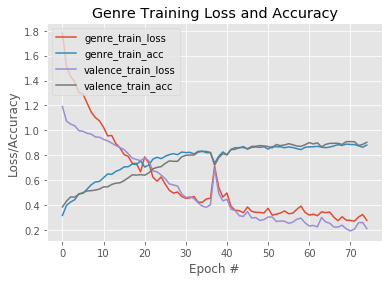

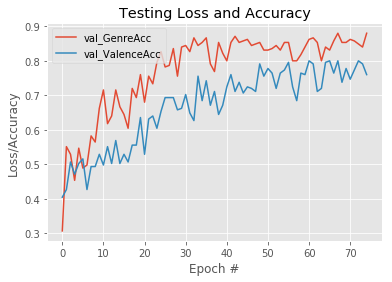

In [35]:

#plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["genreOutput_loss"], label="genre_train_loss")
plt.plot(np.arange(0, N), H.history["genreOutput_categorical_accuracy"], label="genre_train_acc")
plt.plot(np.arange(0, N), H.history["valenceOutput_loss"], label="valence_train_loss")
plt.plot(np.arange(0, N), H.history["valenceOutput_categorical_accuracy"], label="valence_train_acc")
plt.title("Genre Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["val_genreOutput_categorical_accuracy"], label="val_GenreAcc")
plt.plot(np.arange(0, N), H.history["val_valenceOutput_categorical_accuracy"], label="val_ValenceAcc")
plt.title("Testing Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")





In [70]:
H.history.keys()

dict_keys(['val_loss', 'val_genreOutput_loss', 'val_valenceOutput_loss', 'val_genreOutput_categorical_accuracy', 'val_valenceOutput_categorical_accuracy', 'loss', 'genreOutput_loss', 'valenceOutput_loss', 'genreOutput_categorical_accuracy', 'valenceOutput_categorical_accuracy'])

In [22]:
loaded_model.metrics_names

['loss',
 'genreOutput_loss',
 'valenceOutput_loss',
 'genreOutput_categorical_accuracy',
 'valenceOutput_categorical_accuracy']

In [35]:
from sklearn.metrics import confusion_matrix

In [65]:
pred = model.predict(testX)

In [71]:
cmGenres=confusion_matrix(pred[0].argmax(axis=1), testGenres.argmax(axis=1))
cmValence=confusion_matrix(pred[1].argmax(axis=1), testValence.argmax(axis=1))

In [72]:
label_encoder.classes_

array(['Electronic', 'Folk', 'Hip-Hop', 'Instrumental', 'Pop', 'Rock'],
      dtype='<U12')

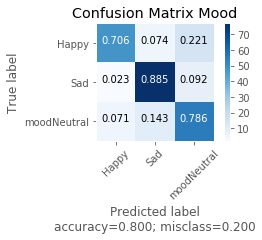

In [84]:
plot_confusion_matrix(cmValence,label_encoder_valence.classes_,4,3,'Confusion Matrix Mood', normalize=True)

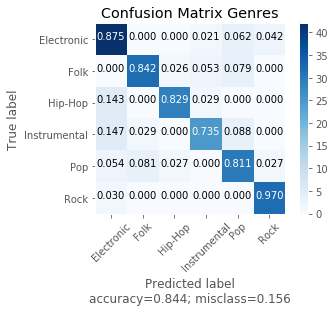

In [82]:
plot_confusion_matrix(cmGenres,label_encoder.classes_,5,4,'Confusion Matrix Genres', normalize=True)

In [11]:
danceability = featData[:,0]
energy = featData[:,1]
valence = featData[:,2]
accousticness = featData[:,3]

(array([770., 530., 620., 610., 400., 430., 380., 210., 310., 240.]),
 array([0.0306 , 0.12554, 0.22048, 0.31542, 0.41036, 0.5053 , 0.60024,
        0.69518, 0.79012, 0.88506, 0.98   ]),
 <a list of 10 Patch objects>)

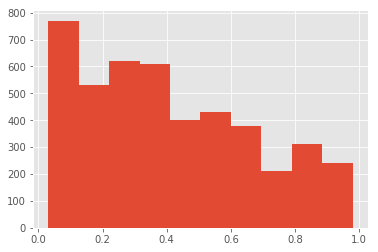

In [33]:
'''Checking out the distribution of valence in the total dataset'''
plt.hist(valence)

In [58]:
np.set_printoptions(suppress=True)

model.summary()

In [ ]:
'''Hyper params grid search'''
param = Params('params.json')
param.dict['LR']=.001
param.dict['BatchSize']=60
param.dict['regparam']=.001
param.dict['dropout'] = .5
param.dict['FCLayers']=1

LRparams = [.01,.001]
BSparams=[75,150]
L2Params = [.001,.002,.003]
df = pd.DataFrame(index = range(0,100), columns =['LR','BS','L2','genre_acc','valence_acc'])
param.dict['dropout']=.5
count=0
EPOCHS=50

for LR in LRparams:
    for BS in BSparams:
        for L2 in L2Params:
            param.dict['LR']=LR
            param.dict['BatchSize']=BS
            param.dict['regparam']=L2
            print('LR:{:.3f}, BS:{:.2f}, L2:{:.4f}'.format(LR,BS,L2))
            model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
              depth=IMAGE_DIMS[2], classesGenres = len(label_encoder.classes_), classesValence = len(label_encoder_valence.classes_)
              ,param=param, activate="softmax")

            opt = Adam(lr=param.LR)               
              
            model.compile(loss={'genreOutput': 'categorical_crossentropy', 'valenceOutput': 'categorical_crossentropy'},
              loss_weights={'genreOutput': 1, 'valenceOutput': 1.25}, optimizer=opt,
                     metrics={'genreOutput':'categorical_accuracy', 'valenceOutput':'categorical_accuracy'})

            H = model.fit(trainX,{"genreOutput": trainGenres, "valenceOutput": trainValence},
                          validation_data=(devX, {"genreOutput": devGenres, "valenceOutput": devValence}),
                          epochs=EPOCHS, verbose=1)
            bestaccgenre = np.max(H.history['val_genreOutput_categorical_accuracy'])
            print('bestaccG:{:.3f}'.format(bestaccgenre))
            bestaccvalence = np.max(H.history['val_valenceOutput_categorical_accuracy'])
            print('bestaccV:{:.3f}'.format(bestaccvalence))
            df['LR'][count]=LR
            df['BS'][count]=BS
            df['L2'][count]=L2
            df['genre_acc'][count]=bestaccgenre
            df['valence_acc'][count]=bestaccvalence
            count= count+1
print(df)
            

In [38]:
df.to_csv('df.csv')

In [39]:
df=df.dropna()

In [40]:
df

,LR,BS,L2,genre_acc,valence_acc
0,0.01,75,0.001,0.84,0.76
1,0.01,75,0.002,0.755556,0.728889
2,0.01,75,0.003,0.795556,0.702222
3,0.01,150,0.001,0.804444,0.742222
4,0.01,150,0.002,0.755556,0.702222
5,0.01,150,0.003,0.795556,0.675556
6,0.001,75,0.001,0.871111,0.782222
7,0.001,75,0.002,0.857778,0.773333
8,0.001,75,0.003,0.848889,0.795556
9,0.001,150,0.001,0.884444,0.804444


In [77]:
def plot_confusion_matrix(cm,
                          target_names,
                          figsizex,
                          figsizey,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(figsizex, figsizey))
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        plt.grid(False)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()